In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import os
import ast
import time
import matplotlib.pyplot as plt

import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Add the grandparent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from Utils import FE_helper as FE

# optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\yangs\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Load the data
train_df = pd.read_csv('../Data/original/train_2025.csv') 
test_df = pd.read_csv('../Data/original/test_2025.csv')

train_df = FE.add_features(train_df)
test_df = FE.add_features(test_df)

test_id = test_df['claim_number']
train_id = train_df['claim_number']
target = train_df['fraud']

ignore_var = ['claim_date.day', 'claim_date.weekofyear']
train_df = FE.drop_ignored_columns(train_df, ignore_var)
test_df = FE.drop_ignored_columns(test_df, ignore_var)

In [3]:
def objective(trial, full_train_df, kfoldcv = 20, drop = []):
    ignore_var = ['claim_number', 'fraud']
    y = full_train_df['fraud']

    params = {
        'objective': 'binary',
        'metric': 'None',
        'is_unbalance': True,
        'boosting': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'verbose': -1
    }

    skf = StratifiedKFold(n_splits=kfoldcv, shuffle=True)
    best_thresholds = []
    f1_scores = []

    for train_idx, val_idx in skf.split(full_train_df, y):
        raw_train = full_train_df.iloc[train_idx].copy()
        raw_val = full_train_df.iloc[val_idx].copy()

        # Preprocess inside the fold (train fitted only on fold-train)
        X_train_df, X_val_df = FE.preprocess_train_test(raw_train, raw_val, ignore_var=ignore_var)
        X_train_df.drop(columns=drop, inplace=True, errors='ignore')
        X_val_df.drop(columns=drop, inplace=True, errors='ignore')
        
        y_train = raw_train['fraud']
        y_val = raw_val['fraud']

        lgb_train = lgb.Dataset(X_train_df, y_train)
        lgb_val = lgb.Dataset(X_val_df, y_val, reference=lgb_train)

        model = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_val])
        importance = dict(zip(model.feature_name(), model.feature_importance()))
        trial.set_user_attr('feature_importance', importance)

        # Predict + threshold tune
        probs = model.predict(X_val_df)
        thresholds = np.linspace(0.1, 0.9, 50)
        f1s = [f1_score(y_val, probs > t) for t in thresholds]

        best_f1 = max(f1s)
        best_threshold = thresholds[np.argmax(f1s)]

        f1_scores.append(best_f1)
        best_thresholds.append(best_threshold)
        mean_threshold = np.mean(best_thresholds)
        
        trial.set_user_attr('mean_threshold', mean_threshold)
        
    return np.mean(f1_scores)


In [ ]:
# Initialize
low_importance_features = []
best_f1_overall = 0
round_logs = []

# Setup log file name
timestamp = time.strftime("%m%d_%H%M")
log_file = f"logs/feature_pruning_log_{timestamp}.csv"

# Loop parameters
max_rounds = 25
min_features = 40
n_trials_per_round = 20
cutoff_quantile = 0.03

for round_idx in range(max_rounds):
    print(f"\n=== Round {round_idx + 1} ===")
    
    # Run Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, train_df, kfoldcv= 5, drop=low_importance_features),
                   n_trials=n_trials_per_round)
    
    best_f1 = study.best_value
    print(f"Best F1 this round: {best_f1:.4f}")
    
    # Track best overall F1
    if best_f1 > best_f1_overall:
        best_f1_overall = best_f1
    
    # Collect feature importance
    feature_scores = {}
    for t in study.trials:
        imp = t.user_attrs.get('feature_importance')
        if imp is not None:
            for k, v in imp.items():
                feature_scores.setdefault(k, []).append(v)
    agg_importance = {
        k: np.mean(v)
        for k, v in feature_scores.items()
    }
    importance_df = pd.DataFrame(list(agg_importance.items()), columns=['feature', 'mean_importance'])
    
    # Identify low-importance features
    threshold = importance_df['mean_importance'].quantile(cutoff_quantile)
    dropped_features = importance_df[
        importance_df['mean_importance'] <= threshold
    ]['feature'].tolist()
    
    print(f"Dropping {len(dropped_features)} features (bottom {cutoff_quantile * 100:.1f}%)")
    print("Features to drop:", dropped_features)
    
    # Update drop list
    low_importance_features.extend(dropped_features)
    
    # Log round
    round_logs.append({
        'round': round_idx + 1,
        'f1_this_round': best_f1,
        'best_f1_overall': best_f1_overall,
        'num_features_remaining': len(importance_df) - len(low_importance_features),
        'features_dropped_this_round': dropped_features
    })
    
    # Save to CSV after each round
    pd.DataFrame(round_logs).to_csv(log_file, index=False)
    print(f"Log saved to {log_file}")
    
    # Check stopping condition
    num_features_left = len(importance_df) - len(dropped_features)
    if num_features_left <= min_features:
        print(f"Stopping: reached minimum feature count ({min_features})")
        break

print("\n=== Finished all rounds ===")
print(f"Best overall F1: {best_f1_overall:.4f}")
print(f"Final log saved to {log_file}")


In [10]:
feature_prune = pd.read_csv('logs/feature_pruning_log_0503_1741.csv')
LIF = FE.get_cumulative_dropped_features(feature_prune, 16)
len(LIF)

41

In [12]:
feature_prune = pd.read_csv('logs/feature_pruning_log_0503_1131.csv')
LIF = FE.get_cumulative_dropped_features(feature_prune, 16)
# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_df, kfoldcv=5, drop=LIF),
                n_trials=20)

best_f1 = study.best_value
print(f"Best F1 this round: {best_f1:.4f}")

[I 2025-05-03 18:42:21,290] A new study created in memory with name: no-name-e1ba5594-b237-4261-8076-7a292ea0ca65
[I 2025-05-03 18:42:28,760] Trial 0 finished with value: 0.3461776410311706 and parameters: {'num_leaves': 122, 'feature_fraction': 0.8435657028954127, 'bagging_fraction': 0.7153498561241091, 'bagging_freq': 4, 'learning_rate': 0.033881129193664615}. Best is trial 0 with value: 0.3461776410311706.
[I 2025-05-03 18:42:35,988] Trial 1 finished with value: 0.33989956919178144 and parameters: {'num_leaves': 127, 'feature_fraction': 0.4429912544448497, 'bagging_fraction': 0.8333712971657032, 'bagging_freq': 3, 'learning_rate': 0.05712366557198654}. Best is trial 0 with value: 0.3461776410311706.
[I 2025-05-03 18:42:41,575] Trial 2 finished with value: 0.3583520491050041 and parameters: {'num_leaves': 107, 'feature_fraction': 0.3124476377790147, 'bagging_fraction': 0.3480362660740429, 'bagging_freq': 9, 'learning_rate': 0.010714032290294365}. Best is trial 2 with value: 0.3583520

Best F1 this round: 0.3657


In [5]:
feature_prune = pd.read_csv('logs/feature_pruning_log_0503_1131.csv')
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_df, kfoldcv=5, drop=[FE.get_cumulative_dropped_features(feature_prune, 1)]),
                n_trials=20)

best_f1 = study.best_value
print(f"Best F1 this round: {best_f1:.4f}")

[I 2025-05-03 17:37:57,360] A new study created in memory with name: no-name-f3171252-1cb4-4737-a087-a829ce88cb39
[I 2025-05-03 17:38:04,997] Trial 0 finished with value: 0.32926894594283157 and parameters: {'num_leaves': 121, 'feature_fraction': 0.5985664800605348, 'bagging_fraction': 0.8822448618042205, 'bagging_freq': 2, 'learning_rate': 0.07707979720447379}. Best is trial 0 with value: 0.32926894594283157.
[I 2025-05-03 17:38:12,076] Trial 1 finished with value: 0.30398581909680317 and parameters: {'num_leaves': 111, 'feature_fraction': 0.7192796105111134, 'bagging_fraction': 0.5857414828560623, 'bagging_freq': 2, 'learning_rate': 0.0922697556495046}. Best is trial 0 with value: 0.32926894594283157.
[I 2025-05-03 17:38:16,555] Trial 2 finished with value: 0.34936066225188067 and parameters: {'num_leaves': 58, 'feature_fraction': 0.3269050824165193, 'bagging_fraction': 0.8967457653577855, 'bagging_freq': 8, 'learning_rate': 0.05020597387255343}. Best is trial 2 with value: 0.3493606

Best F1 this round: 0.3681


In [21]:
best_threshold = study.best_trial.user_attrs['mean_threshold']
best_params = study.best_params

best_params.update({
    'objective': 'binary',
    'metric': 'None',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'verbose': -1
})


X_train_df, X_test_df = FE.preprocess_train_test(train_df, test_df, ignore_var=['claim_number', 'fraud'])

X_train_df.drop(columns=LIF, inplace=True, errors='ignore')
X_test_df.drop(columns=LIF, inplace=True, errors='ignore')

lgb_train_full = lgb.Dataset(X_train_df, target)

final_model = lgb.train(best_params, lgb_train_full, num_boost_round=500)

probs_test = final_model.predict(X_test_df)


In [22]:
timestamp = datetime.now().strftime('%m%d_%H%M')

final_preds = (probs_test > best_threshold).astype(int)

submission = pd.DataFrame({
    'claim_number': test_id,
    'fraud': final_preds
})

submission.to_csv(f'../Submit/submission_{timestamp}.csv', index=False)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

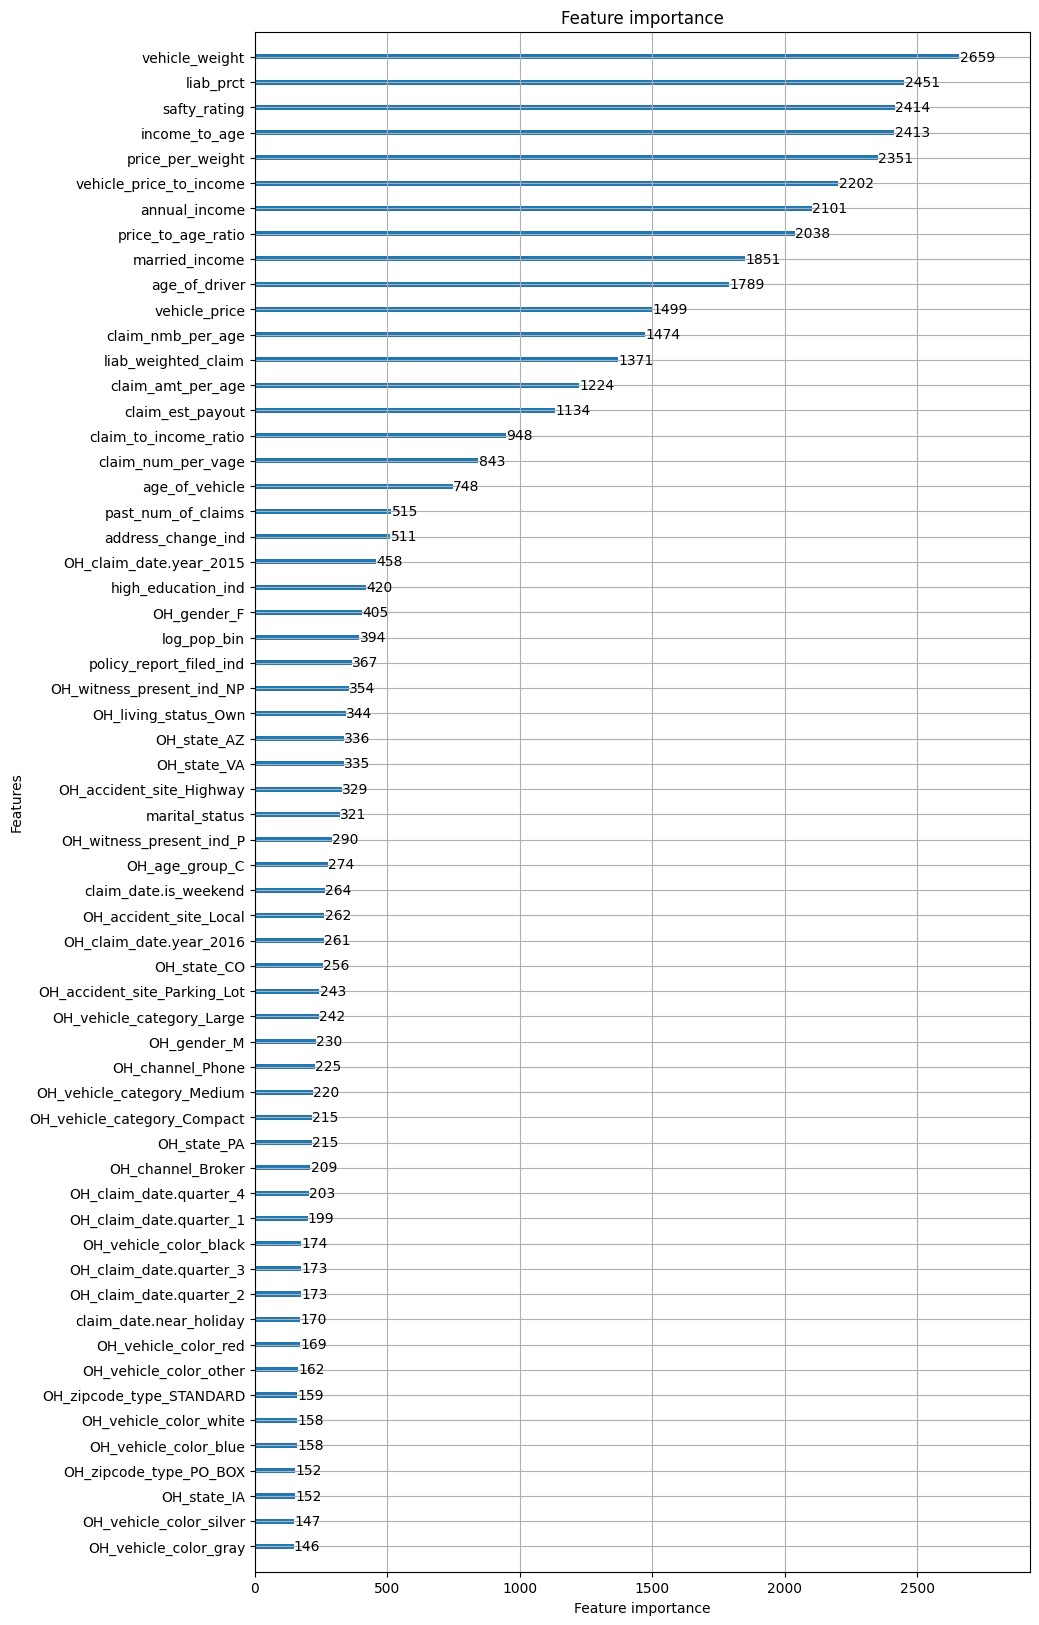

In [23]:
lgb.plot_importance(final_model, figsize=(10, 20))